# Multiclass Classification of Fashion-MNIST dataset with Pytorch
## Part-2: Implementing Regularization

In [46]:
!pip install torchmetrics --quiet

In [47]:
# set this flag to True when you run this Notebook on Google Collaboratory
USE_COLAB = True

import os
import sys

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    # now add correct module folder to sys.path
    PYTORCH_NOTEBOOKS_PATH = "/content/drive/My Drive/Colab Notebooks/Pytorch"
    assert os.path.exists(PYTORCH_NOTEBOOKS_PATH), f"FATAL: {PYTORCH_NOTEBOOKS_PATH} does not exist!"
    sys.path.insert(0, PYTORCH_NOTEBOOKS_PATH)
    print(f"sys.path: {sys.path}", flush=True)
    assert os.path.exists(os.path.join(PYTORCH_NOTEBOOKS_PATH, "torch_training_toolkit.py")), \
        f"FATAL ERROR: torch_training_toolkit not found!"
    MODEL_SAVE_DIR = os.path.join(PYTORCH_NOTEBOOKS_PATH, "model_states")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')

print(f"Model states will be saved to {MODEL_SAVE_DIR}")

if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)


import torch_training_toolkit as t3

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
sys.path: ['/content/drive/My Drive/Colab Notebooks/Pytorch', '/content/drive/My Drive/Colab Notebooks/Pytorch', '/content/drive/My Drive/Colab Notebooks/Pytorch', '/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython']
Model states will be saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states


## Standard Imports

In [48]:
import warnings
warnings.filterwarnings('ignore')

import sys, os, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# tweaks for libraries
np.set_printoptions(precision=6, linewidth=1024, suppress=True)
plt.style.use('seaborn-v0_8')
sns.set(style='darkgrid', context='notebook', font_scale=1.2)

# Pytorch imports
import torch
print(f'Using Pytorch version {torch.__version__}. ' +
      f'GPU {"is available :)" if torch.cuda.is_available() else "is not available :("}')
import torch.nn as nn
from torchvision import datasets, transforms
from torch import optim
import torchsummary
import torchmetrics

# My helper functions for training/evaluating etc.
import torch_training_toolkit as t3

SEED = t3.seed_all(41)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using Pytorch version 2.1.0+cu121. GPU is available :)


## Helper Functions

In [49]:
def load_data():
    """
    load the data using datasets API. We also split the test_dataset into
    cross-val/test datasets using 80:20 ration
    """
    mean, std = 0.5, 0.5
    transformations = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    train_dataset =  datasets.FashionMNIST(root='./data', train=True, download=True,
                                   transform=transformations)

    print("No of training records: %d" % len(train_dataset))

    test_dataset = datasets.FashionMNIST('./data', train=False, download=True,
                                  transform=transformations)
    print("No of test records: %d" % len(test_dataset))

    # lets split the test dataset into val_dataset & test_dataset -> 8000:2000 records
    val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [8000, 2000])
    print("No of cross-val records: %d" % len(val_dataset))
    print("No of test records: %d" % len(test_dataset))

    return train_dataset, val_dataset, test_dataset

In [50]:
def display_sample(sample_images, sample_labels, grid_shape=(10, 10), plot_title=None,
                   sample_predictions=None):
    # just in case these are not imported!
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.style.use('seaborn')

    num_rows, num_cols = grid_shape
    assert sample_images.shape[0] == num_rows * num_cols

    # a dict to help encode/decode the labels
    FASHION_LABELS = {
        0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot',
    }

    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.10)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows, num_cols, figsize=(14, 10),
            gridspec_kw={"wspace": 0.05, "hspace": 0.35}, squeeze=True)  # 0.03, 0.25
        #fig = ax[0].get_figure()
        f.tight_layout()
        f.subplots_adjust(top=0.90) # 0.93

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                # show selected image
                ax[r, c].imshow(sample_images[image_index].squeeze(), cmap="Greys", interpolation='nearest')

                if sample_predictions is None:
                    # but show the prediction in the title
                    title = ax[r, c].set_title(f"{FASHION_LABELS[sample_labels[image_index]]}")
                else:
                    pred_matches_actual = (
                                sample_labels[image_index] == sample_predictions[image_index])
                    if pred_matches_actual:
                        # show title from prediction or actual in green font
                        title = '%s' % FASHION_LABELS[sample_predictions[image_index]]
                        title_color = 'g'
                    else:
                        # show title as actual/prediction in red font
                        title = '%s/%s' % (FASHION_LABELS[sample_labels[image_index]],
                                           FASHION_LABELS[sample_predictions[image_index]])
                        title_color = 'r'

                    # but show the prediction in the title
                    title = ax[r, c].set_title(title)
                    # if prediction is incorrect title color is red, else green
                    plt.setp(title, color=title_color)

        if plot_title is not None:
            plt.suptitle(plot_title)
        plt.show()
        plt.close()

In [51]:
# (down)load the data
train_dataset, val_dataset, test_dataset = load_data()

No of training records: 60000
No of test records: 10000
No of cross-val records: 8000
No of test records: 2000


images.shape = torch.Size([64, 1, 28, 28]), labels.shape=torch.Size([64])


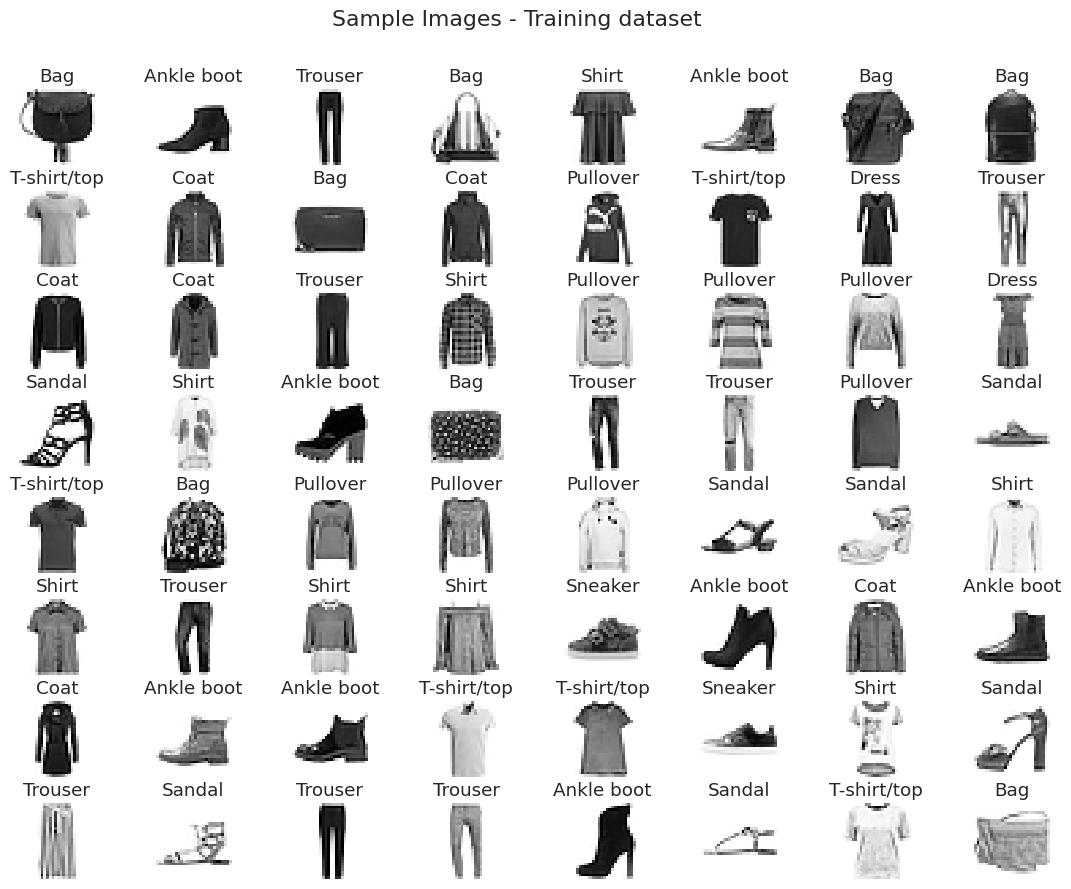

In [52]:
# display a sample
trainloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
data_iter = iter(trainloader)
images, labels = next(data_iter)  # fetch first batch of 64 images & labels
print(f'images.shape = {images.shape}, labels.shape={labels.shape}')
#print(f'labels = {labels[:10]}')
display_sample(images.cpu().numpy(), labels.cpu().numpy(), grid_shape=(8, 8),
               plot_title='Sample Images - Training dataset')

## Implementing L2 Regularization

In [53]:
# some globals
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 28, 28, 1, 10
NUM_EPOCHS, BATCH_SIZE, LEARNING_RATE, L2_REG = 25, 128, 0.001, 0.0025
PY_MODEL_SAVE_PATH_L2 = os.path.join(MODEL_SAVE_DIR, 'pyt_fashion_mnist_cnn_l2.pyt')
print(f"Model will be saved to {PY_MODEL_SAVE_PATH_L2}")

Model will be saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/pyt_fashion_mnist_cnn_l2.pyt


### Define our Model

This is the same model as before, except that we are adding L2 regularization by specifying the `weight_decay` parameter in the optimizer's constructor.

In [54]:
class FMNistNet(nn.Module):
    def __init__(self):
        super(FMNistNet, self).__init__()
        self.net = nn.Sequential(
            t3.Conv2d(1, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            t3.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            t3.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            t3.Conv2d(128, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            t3.Conv2d(128, 256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            t3.Conv2d(256, 256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),

            nn.Linear(256*3*3, 1024),
            nn.ReLU(),

            nn.Linear(1024, 512),
            nn.ReLU(),

            nn.Linear(512, NUM_CLASSES)
        )

    def forward(self, x):
        return self.net(x)

In [55]:
model = FMNistNet().to(DEVICE)
print(torchsummary.summary(model, (NUM_CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
       BatchNorm2d-3           [-1, 64, 28, 28]             128
            Conv2d-4           [-1, 64, 28, 28]          36,928
              ReLU-5           [-1, 64, 28, 28]               0
       BatchNorm2d-6           [-1, 64, 28, 28]             128
         MaxPool2d-7           [-1, 64, 14, 14]               0
            Conv2d-8          [-1, 128, 14, 14]          73,856
              ReLU-9          [-1, 128, 14, 14]               0
      BatchNorm2d-10          [-1, 128, 14, 14]             256
           Conv2d-11          [-1, 128, 14, 14]         147,584
             ReLU-12          [-1, 128, 14, 14]               0
      BatchNorm2d-13          [-1, 128, 14, 14]             256
        MaxPool2d-14            [-1, 12

### Train the model

In [56]:
loss_fn = nn.CrossEntropyLoss()
metrics_map = {
    "acc": torchmetrics.classification.MulticlassAccuracy(num_classes=NUM_CLASSES)
}
trainer = t3.Trainer(
    loss_fn = loss_fn, device=DEVICE, metrics_map = metrics_map,
    epochs=NUM_EPOCHS, batch_size=BATCH_SIZE
)
# >>> here is the change to implement L2 regularization - add a weight_decay=XXX param
# to your optimizer. You can use any optimizer, but Adam works best for most classification
# usecases
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE, weight_decay=L2_REG)

In [57]:
hist = trainer.fit(model, optimizer, train_dataset, validation_dataset=val_dataset)

Cross training on 'cuda' with 60,000 training and 8,000 cross-validation records...
Epoch ( 1/25): (60000/60000) -> loss: 0.3968 - acc: 0.8557 - val_loss: 0.3194 - val_acc: 0.8797
Epoch ( 2/25): (60000/60000) -> loss: 0.2788 - acc: 0.8996 - val_loss: 0.2852 - val_acc: 0.8961
Epoch ( 3/25): (60000/60000) -> loss: 0.2576 - acc: 0.9060 - val_loss: 0.2699 - val_acc: 0.9030
Epoch ( 4/25): (60000/60000) -> loss: 0.2395 - acc: 0.9146 - val_loss: 0.2578 - val_acc: 0.9055
Epoch ( 5/25): (60000/60000) -> loss: 0.2247 - acc: 0.9206 - val_loss: 0.2483 - val_acc: 0.9070
Epoch ( 6/25): (60000/60000) -> loss: 0.2148 - acc: 0.9256 - val_loss: 0.2284 - val_acc: 0.9160
Epoch ( 7/25): (60000/60000) -> loss: 0.2022 - acc: 0.9289 - val_loss: 0.2322 - val_acc: 0.9171
Epoch ( 8/25): (60000/60000) -> loss: 0.1923 - acc: 0.9321 - val_loss: 0.2216 - val_acc: 0.9227
Epoch ( 9/25): (60000/60000) -> loss: 0.1843 - acc: 0.9350 - val_loss: 0.2291 - val_acc: 0.9199
Epoch (10/25): (60000/60000) -> loss: 0.1755 - acc: 

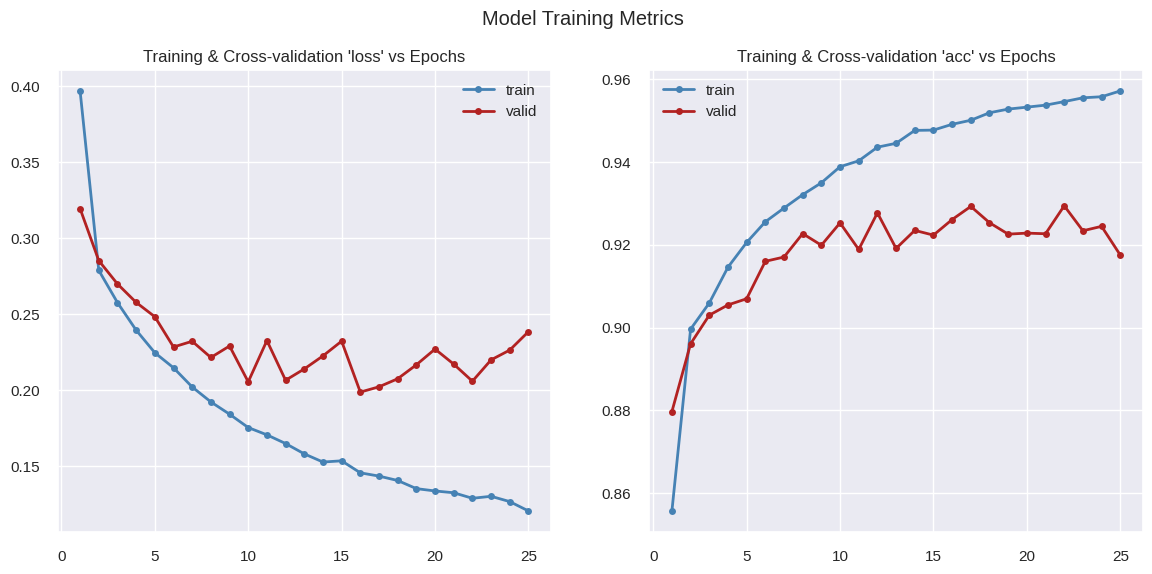

In [58]:
hist.plot_metrics(title = "Model Training Metrics", fig_size = (14, 6))

### Evaluate Performance

In [59]:
# evaluate performance
print('Evaluating model performance...')
metrics = trainer.evaluate(model, train_dataset)
print(f"Training metrics -> loss: {metrics['loss']:.4f} - acc: {metrics['acc']:.4f}")
metrics = trainer.evaluate(model, val_dataset)
print(f"Cross-val metrics -> loss: {metrics['loss']:.4f} - acc: {metrics['acc']:.4f}")
metrics = trainer.evaluate(model, test_dataset)
print(f"Testing metrics   -> loss: {metrics['loss']:.4f} - acc: {metrics['acc']:.4f}")

Evaluating model performance...
Evaluating (60000/60000) -> loss: 0.1466 - acc: 0.9275('\rEvaluating (60000/60000) -> loss: 0.1211 - acc: 0.9590',)
Training metrics -> loss: 0.1211 - acc: 0.9590
Evaluating (8000/8000) -> loss: 0.2631 - acc: 0.9133('\rEvaluating (8000/8000) -> loss: 0.2383 - acc: 0.9179',)
Cross-val metrics -> loss: 0.2383 - acc: 0.9179
Evaluating (2000/2000) -> loss: 0.1574 - acc: 0.9496('\rEvaluating (2000/2000) -> loss: 0.2450 - acc: 0.9214',)
Testing metrics   -> loss: 0.2450 - acc: 0.9214


### Observations
>Configuration | Training Acc | Cross-val Acc | Test Acc | Observation
>:---|:---:|:---:|:---:|:---|
>**Model**|99-100%|93-94%|92-93%| Overfitting
>**Base Model + L2 regularization**|~96-97%|~91-92%|~92-93%| Still Overfitting

From the table & graphs we observe that:
* Overfitting has reduced - from training accuracy of ~99%, it has come down to 96%, whereas the cross-val & test accuracies have decreased just a wee bit.
* You will also observe from the plots that the curves do not diverge as much as they did previously.

The model is still overfitting, though much less than before.

Next, we will explore another regularization technique used in deep learning - viz. **dropout regularization**.

In [60]:
t3.save_model(model, PY_MODEL_SAVE_PATH_L2)
del model

Pytorch model saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/pyt_fashion_mnist_cnn_l2.pyt


### Making Predictions

In [61]:
model = FMNistNet().to(DEVICE)
t3.load_model(model, PY_MODEL_SAVE_PATH_L2)
print(torchsummary.summary(model, (NUM_CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT)))

Pytorch model loaded from /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/pyt_fashion_mnist_cnn_l2.pyt
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
       BatchNorm2d-3           [-1, 64, 28, 28]             128
            Conv2d-4           [-1, 64, 28, 28]          36,928
              ReLU-5           [-1, 64, 28, 28]               0
       BatchNorm2d-6           [-1, 64, 28, 28]             128
         MaxPool2d-7           [-1, 64, 14, 14]               0
            Conv2d-8          [-1, 128, 14, 14]          73,856
              ReLU-9          [-1, 128, 14, 14]               0
      BatchNorm2d-10          [-1, 128, 14, 14]             256
           Conv2d-11          [-1, 128, 14, 14]         147,584
             ReLU-12          [-1, 128, 14, 14]    

In [62]:
# run predictions
y_pred, y_true = trainer.predict(model, test_dataset)
y_pred = np.argmax(y_pred, axis = 1)
print('Sample labels (50): ', y_true[:50])
print('Sample predictions: ', y_true[:50])
print('We got %d/%d incorrect!' % ((y_pred != y_true).sum(), len(y_true)))

Sample labels (50):  [6 4 5 4 8 0 8 9 5 3 5 4 3 3 0 9 1 2 5 0 8 9 8 0 6 4 7 6 5 0 1 8 1 1 9 7 0 7 5 3 4 4 2 1 9 5 8 4 8 0]
Sample predictions:  [6 4 5 4 8 0 8 9 5 3 5 4 3 3 0 9 1 2 5 0 8 9 8 0 6 4 7 6 5 0 1 8 1 1 9 7 0 7 5 3 4 4 2 1 9 5 8 4 8 0]
We got 161/2000 incorrect!


Displaying sample predictions...


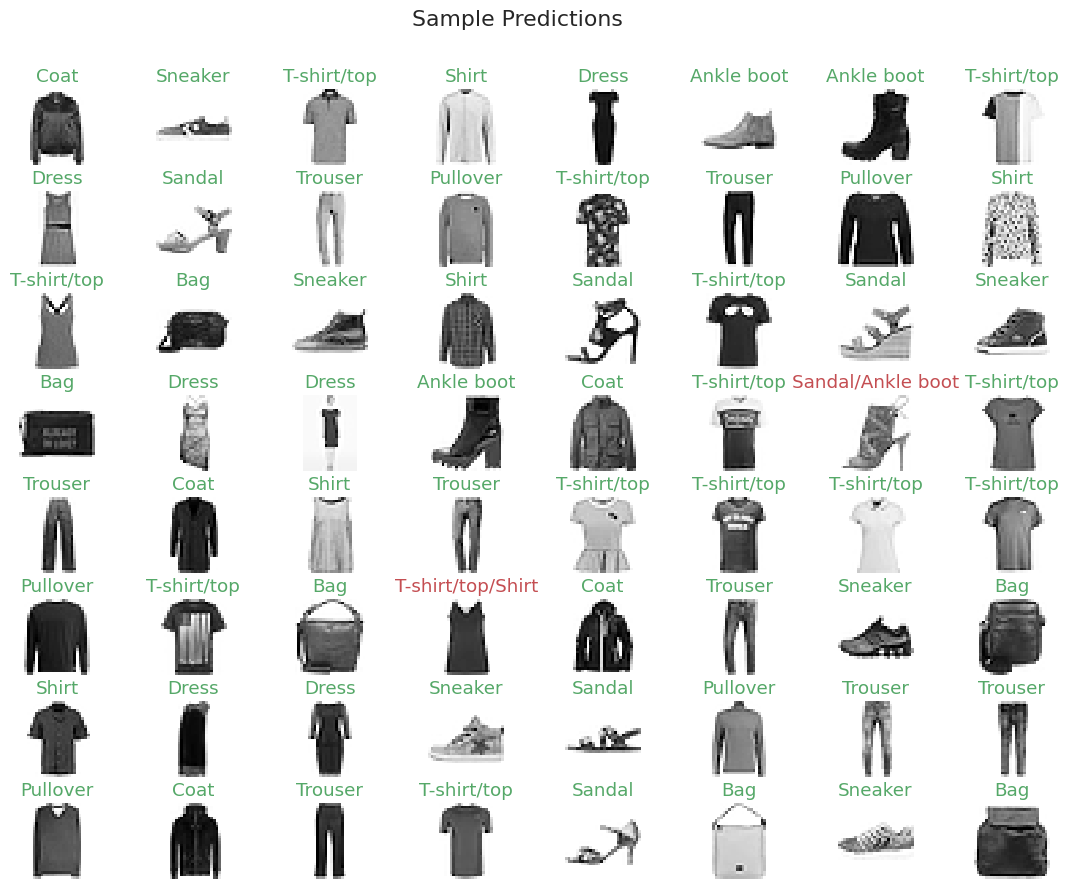

In [63]:
# display sample
print('Displaying sample predictions...')
trainloader = torch.utils.data.DataLoader(
    test_dataset, batch_size = 64, shuffle = True
)
data_iter = iter(trainloader)
images, labels = next(data_iter)  # fetch a batch of 64 random images
preds = trainer.predict(model, images)
preds = np.argmax(preds, axis = 1)
display_sample(
    images, labels.numpy(), sample_predictions = preds,
    grid_shape = (8, 8), plot_title = 'Sample Predictions'
)

In [64]:
del model

### Summary (L2 Regularization)
* The base model is significantly overfitting the data
* We get 153/2000 incorrect predictions from test dataset - this is worse than the base model (Base Model - 149/2000 incorrect). So I will definately not use this model.

## Implementing Dropout Regularization
Dropout regularization technique randomly 'drops' nodes in a layer during training, thereby applying the regularization effect to the overall model. We add an `nn.Dropout` layer with dropout percentage like so: `nn.Dropout(p=0.2)` meaning _randomly drop 20% of layer's nodes_ during training.

You can place the dropout layers anywhere, after the `nn.Linear()` or `nn.Conv2d()` layers, but I prefer to place them after the `nn.BatchNorm2d` layers.

In this section, we'll apply _Dropout Regularization_ only, so the `weight_decay` parameter is dropped from the optimizer's constructor.

In [65]:
# some globals
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 28, 28, 1, 10
NUM_EPOCHS, BATCH_SIZE, LEARNING_RATE, L2_REG = 25, 128, 0.001, 0.0025
PY_MODEL_SAVE_PATH_DO = os.path.join(MODEL_SAVE_DIR, 'pyt_fashion_mnist_cnn_do.pyt')
print(f"Model will be saved to {PY_MODEL_SAVE_PATH_DO}")

Model will be saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/pyt_fashion_mnist_cnn_do.pyt


### Defining our Model

In [66]:
class FMNistNetDO(nn.Module):
    def __init__(self):
        super(FMNistNetDO, self).__init__()
        self.net = nn.Sequential(
            t3.Conv2d(1, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            t3.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.20),

            t3.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            t3.Conv2d(128, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.30),

            t3.Conv2d(128, 256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            t3.Conv2d(256, 256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.40),

            nn.Flatten(),
            nn.Dropout(0.40),

            nn.Linear(256*3*3, 1024),
            nn.ReLU(),
            nn.Dropout(0.30),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.30),

            nn.Linear(512, NUM_CLASSES)
        )

    def forward(self, x):
        return self.net(x)

In [67]:
model = FMNistNetDO().to(DEVICE)
print(torchsummary.summary(model, (NUM_CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
       BatchNorm2d-3           [-1, 64, 28, 28]             128
            Conv2d-4           [-1, 64, 28, 28]          36,928
              ReLU-5           [-1, 64, 28, 28]               0
       BatchNorm2d-6           [-1, 64, 28, 28]             128
         MaxPool2d-7           [-1, 64, 14, 14]               0
           Dropout-8           [-1, 64, 14, 14]               0
            Conv2d-9          [-1, 128, 14, 14]          73,856
             ReLU-10          [-1, 128, 14, 14]               0
      BatchNorm2d-11          [-1, 128, 14, 14]             256
           Conv2d-12          [-1, 128, 14, 14]         147,584
             ReLU-13          [-1, 128, 14, 14]               0
      BatchNorm2d-14          [-1, 128,

### Train the model

In [68]:
loss_fn = nn.CrossEntropyLoss()
metrics_map = {
    "acc": torchmetrics.classification.MulticlassAccuracy(num_classes=NUM_CLASSES)
}
trainer = t3.Trainer(
    loss_fn = loss_fn, device=DEVICE, metrics_map = metrics_map,
    epochs=NUM_EPOCHS, batch_size=BATCH_SIZE
)
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE) #, weight_decay=L2_REG)

In [69]:
hist = trainer.fit(model, optimizer, train_dataset, validation_dataset=val_dataset)

Cross training on 'cuda' with 60,000 training and 8,000 cross-validation records...
Epoch ( 1/25): (60000/60000) -> loss: 0.4713 - acc: 0.8263 - val_loss: 0.3091 - val_acc: 0.8866
Epoch ( 2/25): (60000/60000) -> loss: 0.3046 - acc: 0.8909 - val_loss: 0.2883 - val_acc: 0.8937
Epoch ( 3/25): (60000/60000) -> loss: 0.2643 - acc: 0.9046 - val_loss: 0.2509 - val_acc: 0.9049
Epoch ( 4/25): (60000/60000) -> loss: 0.2421 - acc: 0.9138 - val_loss: 0.2382 - val_acc: 0.9146
Epoch ( 5/25): (60000/60000) -> loss: 0.2226 - acc: 0.9205 - val_loss: 0.2182 - val_acc: 0.9201
Epoch ( 6/25): (60000/60000) -> loss: 0.2081 - acc: 0.9270 - val_loss: 0.2096 - val_acc: 0.9215
Epoch ( 7/25): (60000/60000) -> loss: 0.1927 - acc: 0.9301 - val_loss: 0.2347 - val_acc: 0.9143
Epoch ( 8/25): (60000/60000) -> loss: 0.1853 - acc: 0.9348 - val_loss: 0.2039 - val_acc: 0.9281
Epoch ( 9/25): (60000/60000) -> loss: 0.1749 - acc: 0.9374 - val_loss: 0.1891 - val_acc: 0.9316
Epoch (10/25): (60000/60000) -> loss: 0.1647 - acc: 

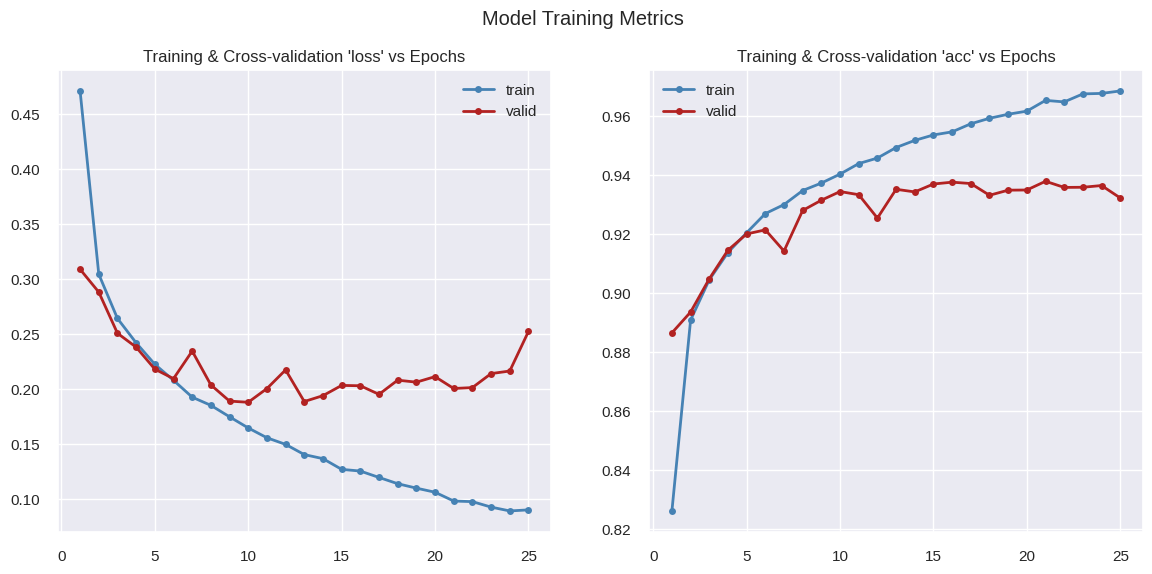

In [70]:
hist.plot_metrics(title = "Model Training Metrics", fig_size = (14, 6))

### Evaluate Performance

In [71]:
# evaluate performance
print('Evaluating model performance...')
metrics = trainer.evaluate(model, train_dataset)
print(f"Training metrics -> loss: {metrics['loss']:.4f} - acc: {metrics['acc']:.4f}")
metrics = trainer.evaluate(model, val_dataset)
print(f"Cross-val metrics -> loss: {metrics['loss']:.4f} - acc: {metrics['acc']:.4f}")
metrics = trainer.evaluate(model, test_dataset)
print(f"Testing metrics   -> loss: {metrics['loss']:.4f} - acc: {metrics['acc']:.4f}")

Evaluating model performance...
Evaluating (60000/60000) -> loss: 0.0715 - acc: 0.9683('\rEvaluating (60000/60000) -> loss: 0.0650 - acc: 0.9758',)
Training metrics -> loss: 0.0650 - acc: 0.9758
Evaluating (8000/8000) -> loss: 0.2269 - acc: 0.9242('\rEvaluating (8000/8000) -> loss: 0.2512 - acc: 0.9322',)
Cross-val metrics -> loss: 0.2512 - acc: 0.9322
Evaluating (2000/2000) -> loss: 0.2733 - acc: 0.9496('\rEvaluating (2000/2000) -> loss: 0.2727 - acc: 0.9247',)
Testing metrics   -> loss: 0.2727 - acc: 0.9247


### Observations
>Configuration | Training Acc | Cross-val Acc | Test Acc | Observation
>:---|:---:|:---:|:---:|:---|
>**Model**|99.40%|92.94%|92.69%| Overfitting
>**Base Model + L2 regularization**|~96-97%|~92-93%|~92-93%| Overfitting has reduced
>**Base Model + Dropout regularization**|~97-98%|~93-94%|~92-93%| Overfitting is almost same as before

From the table & graphs we observe that:
* Overfitting is almost the same as before. However, both the training & cross-val accuracies are better than before.
* The training curves diverge as before, but a bit later and a bit lesser.

So just dropout or just L2 regularizing is giving us similar performance. Dropout is only slightly better for training/cross-val accuracies. Test accuracies are the same as before.

Next let's implement _both_ L2 & dropout regularization. Since we'll be applying more regularization, let us train the model for longer (50 epochs instead of 25, so that model get's _enough opportunity_ to learn from training/cross-val data).

In [72]:
t3.save_model(model, PY_MODEL_SAVE_PATH_DO)
del model

Pytorch model saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/pyt_fashion_mnist_cnn_do.pyt


### Making Predictions

In [73]:
model = FMNistNetDO().to(DEVICE)
t3.load_model(model, PY_MODEL_SAVE_PATH_DO)
print(torchsummary.summary(model, (NUM_CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT)))

Pytorch model loaded from /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/pyt_fashion_mnist_cnn_do.pyt
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
       BatchNorm2d-3           [-1, 64, 28, 28]             128
            Conv2d-4           [-1, 64, 28, 28]          36,928
              ReLU-5           [-1, 64, 28, 28]               0
       BatchNorm2d-6           [-1, 64, 28, 28]             128
         MaxPool2d-7           [-1, 64, 14, 14]               0
           Dropout-8           [-1, 64, 14, 14]               0
            Conv2d-9          [-1, 128, 14, 14]          73,856
             ReLU-10          [-1, 128, 14, 14]               0
      BatchNorm2d-11          [-1, 128, 14, 14]             256
           Conv2d-12          [-1, 128, 14, 14]    

In [74]:
# run predictions
y_pred, y_true = trainer.predict(model, test_dataset)
y_pred = np.argmax(y_pred, axis = 1)
print('Sample labels (50): ', y_true[:50])
print('Sample predictions: ', y_true[:50])
print('We got %d/%d incorrect!' % ((y_pred != y_true).sum(), len(y_true)))

Sample labels (50):  [6 4 5 4 8 0 8 9 5 3 5 4 3 3 0 9 1 2 5 0 8 9 8 0 6 4 7 6 5 0 1 8 1 1 9 7 0 7 5 3 4 4 2 1 9 5 8 4 8 0]
Sample predictions:  [6 4 5 4 8 0 8 9 5 3 5 4 3 3 0 9 1 2 5 0 8 9 8 0 6 4 7 6 5 0 1 8 1 1 9 7 0 7 5 3 4 4 2 1 9 5 8 4 8 0]
We got 154/2000 incorrect!


Displaying sample predictions...


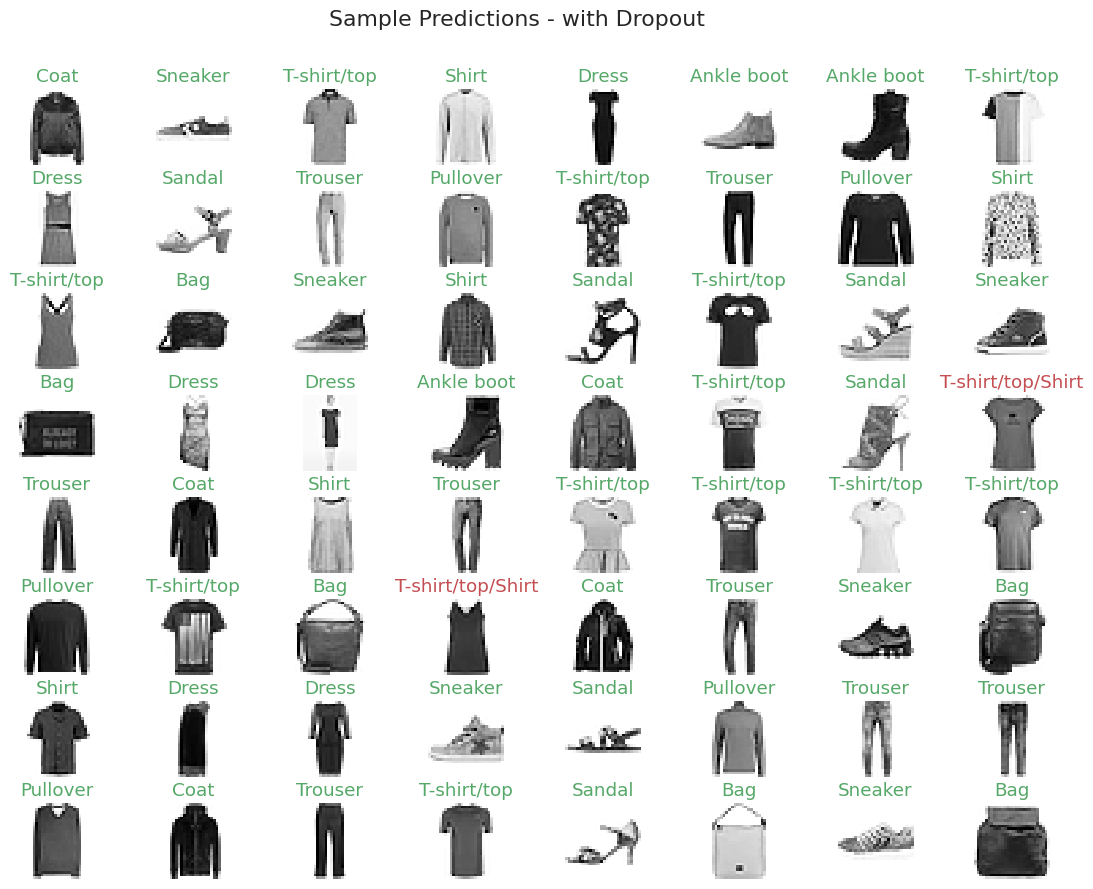

In [75]:
# display sample
print('Displaying sample predictions...')
trainloader = torch.utils.data.DataLoader(
    test_dataset, batch_size = 64, shuffle = True
)
data_iter = iter(trainloader)
images, labels = next(data_iter)  # fetch a batch of 64 random images
preds = trainer.predict(model, images)
preds = np.argmax(preds, axis = 1)
display_sample(
    images, labels.numpy(), sample_predictions = preds,
    grid_shape = (8, 8), plot_title = 'Sample Predictions - with Dropout'
)

### Summary (Dropout Regularization)
<<TODO>>

## Combining L2  and dropout regularization

In this section, we'll combine both the techniques above to check performance of the model.

Our `weight_decay` param in the optimizer constructor makes a comeback. We are making no other changes to the model structure. Since there is greater overall regularization being applied, we'll be training the model longer (for 50 epochs instead of 25 before).

In [76]:
# some globals
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 28, 28, 1, 10
NUM_EPOCHS, BATCH_SIZE, LEARNING_RATE, L2_REG = 50, 128, 0.001, 0.0010
PY_MODEL_SAVE_PATH_L2_DO = os.path.join(MODEL_SAVE_DIR, 'pyt_fashion_mnist_cnn_l2_do.pyt')
print(f"Model will be saved to {PY_MODEL_SAVE_PATH_L2_DO}")

Model will be saved to /content/drive/My Drive/Colab Notebooks/Pytorch/model_states/pyt_fashion_mnist_cnn_l2_do.pyt


### Define the Model

In [77]:
class FMNistNetL2DO(nn.Module):
    # dropout is implemented with nn.Dropout() layers in model
    # L2 Reg is implemented in the optimizer
    def __init__(self):
        super(FMNistNetL2DO, self).__init__()
        self.net = nn.Sequential(
            t3.Conv2d(1, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            t3.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.20),

            t3.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            t3.Conv2d(128, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.30),

            t3.Conv2d(128, 256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            t3.Conv2d(256, 256, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.40),

            nn.Flatten(),
            nn.Dropout(0.40),

            nn.Linear(256*3*3, 1024),
            nn.ReLU(),
            nn.Dropout(0.30),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.30),

            nn.Linear(512, NUM_CLASSES)
        )

    def forward(self, x):
        return self.net(x)

# model = pytk.PytkModuleWrapper(net)
# loss_fn = nn.CrossEntropyLoss()
# # we add regularization to the optimizer
# optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE, weight_decay=L2_REG)
# model.compile(loss=loss_fn, optimizer=optimizer, metrics=['acc'])
# return model, optimizer

In [78]:
model = FMNistNetL2DO().to(DEVICE)
print(torchsummary.summary(model, (NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
       BatchNorm2d-3           [-1, 64, 28, 28]             128
            Conv2d-4           [-1, 64, 28, 28]          36,928
              ReLU-5           [-1, 64, 28, 28]               0
       BatchNorm2d-6           [-1, 64, 28, 28]             128
         MaxPool2d-7           [-1, 64, 14, 14]               0
           Dropout-8           [-1, 64, 14, 14]               0
            Conv2d-9          [-1, 128, 14, 14]          73,856
             ReLU-10          [-1, 128, 14, 14]               0
      BatchNorm2d-11          [-1, 128, 14, 14]             256
           Conv2d-12          [-1, 128, 14, 14]         147,584
             ReLU-13          [-1, 128, 14, 14]               0
      BatchNorm2d-14          [-1, 128,

### Train the model

In [79]:
loss_fn = nn.CrossEntropyLoss()
metrics_map = {
    "acc": torchmetrics.classification.MulticlassAccuracy(num_classes=NUM_CLASSES)
}
trainer = t3.Trainer(
    loss_fn = loss_fn, device=DEVICE, metrics_map = metrics_map,
    epochs=NUM_EPOCHS, batch_size=BATCH_SIZE
)
# L2 reg is implemented in the optimizer
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE, weight_decay=L2_REG)

In [80]:
hist = trainer.fit(model, optimizer, train_dataset, validation_dataset=val_dataset)

Cross training on 'cuda' with 60,000 training and 8,000 cross-validation records...
Epoch ( 1/50): (60000/60000) -> loss: 0.4696 - acc: 0.8298 - val_loss: 0.3089 - val_acc: 0.8847
Epoch ( 2/50): (60000/60000) -> loss: 0.3110 - acc: 0.8881 - val_loss: 0.2765 - val_acc: 0.8988
Epoch ( 3/50): (60000/60000) -> loss: 0.2848 - acc: 0.8978 - val_loss: 0.2474 - val_acc: 0.9115
Epoch ( 4/50): (60000/60000) -> loss: 0.2645 - acc: 0.9068 - val_loss: 0.2564 - val_acc: 0.9093
Epoch ( 5/50): (60000/60000) -> loss: 0.2606 - acc: 0.9093 - val_loss: 0.2504 - val_acc: 0.9067
Epoch ( 6/50): (60000/60000) -> loss: 0.2530 - acc: 0.9116 - val_loss: 0.2411 - val_acc: 0.9115
Epoch ( 7/50): (60000/60000) -> loss: 0.2396 - acc: 0.9158 - val_loss: 0.2314 - val_acc: 0.9141
Epoch ( 8/50): (60000/60000) -> loss: 0.2341 - acc: 0.9178 - val_loss: 0.2323 - val_acc: 0.9162
Epoch ( 9/50): (60000/60000) -> loss: 0.2333 - acc: 0.9182 - val_loss: 0.2523 - val_acc: 0.9093
Epoch (10/50): (60000/60000) -> loss: 0.2281 - acc: 

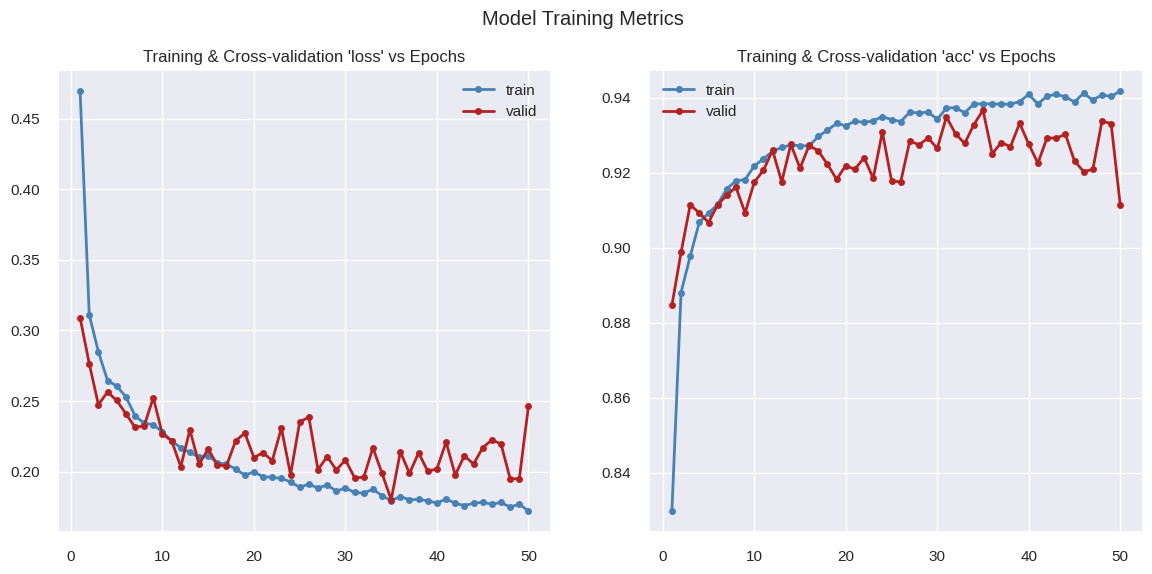

In [81]:
hist.plot_metrics(title = "Model Training Metrics", fig_size = (14, 6))

### Evaluate Performance

In [82]:
# evaluate performance
print('Evaluating model performance...')
metrics = trainer.evaluate(model, train_dataset)
print(f"Training metrics -> loss: {metrics['loss']:.4f} - acc: {metrics['acc']:.4f}")
metrics = trainer.evaluate(model, val_dataset)
print(f"Cross-val metrics -> loss: {metrics['loss']:.4f} - acc: {metrics['acc']:.4f}")
metrics = trainer.evaluate(model, test_dataset)
print(f"Testing metrics   -> loss: {metrics['loss']:.4f} - acc: {metrics['acc']:.4f}")

Evaluating model performance...
Evaluating (60000/60000) -> loss: 0.1220 - acc: 0.9774('\rEvaluating (60000/60000) -> loss: 0.1663 - acc: 0.9386',)
Training metrics -> loss: 0.1663 - acc: 0.9386
Evaluating (8000/8000) -> loss: 0.2003 - acc: 0.9042('\rEvaluating (8000/8000) -> loss: 0.2471 - acc: 0.9118',)
Cross-val metrics -> loss: 0.2471 - acc: 0.9118
Evaluating (2000/2000) -> loss: 0.1824 - acc: 0.9385('\rEvaluating (2000/2000) -> loss: 0.2703 - acc: 0.9115',)
Testing metrics   -> loss: 0.2703 - acc: 0.9115


### Observations

>Configuration | Training Acc | Cross-val Acc | Test Acc | Observation
>:---|:---:|:---:|:---:|:---|
>**Model**|99.40%|92.94%|92.69%| Overfitting
>**Base Model + L2 regularization**|~96-97%|~92-93%|~92-93%| Overfitting has reduced
>**Base Model + Dropout regularization**|~97-98%|~93-94%|~92-93%| Overfitting is almost same as before
>**Base Model + Dropout & L2 regularization**|~93-94%|~91-92%|91-92%| Overfitting has reduced.

You will notice that after implemention both L2 & dropout regularization, overall overfitting has reduced to approx ~ 2% (from ~ 6%) for training accuracies. The cross-val & test accuracies are at a level similar to the base model (~ 91-93%).

* We could try and train this model for many more epochs (say 100) as the loss + accuracy curves have not diverged much
* We could try with various values of L2-REG and dropout percentages to get the best model (iterative approach).
* We can inspect another technique, where we use pre-trained models.

In [ ]:
t3.save_model(model, PY_MODEL_SAVE_PATH_L2_DO)
del model

### Making Predictions

In [ ]:
model = FMNistNetL2DO().to(DEVICE)
t3.load_model(model, PY_MODEL_SAVE_PATH_L2_DO)
print(torchsummary.summary(model, (NUM_CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT)))

In [85]:
# run predictions
y_pred, y_true = trainer.predict(model, test_dataset)
y_pred = np.argmax(y_pred, axis = 1)
print('Sample labels (50): ', y_true[:50])
print('Sample predictions: ', y_true[:50])
print('We got %d/%d incorrect!' % ((y_pred != y_true).sum(), len(y_true)))

Sample labels (50):  [6 4 5 4 8 0 8 9 5 3 5 4 3 3 0 9 1 2 5 0 8 9 8 0 6 4 7 6 5 0 1 8 1 1 9 7 0 7 5 3 4 4 2 1 9 5 8 4 8 0]
Sample predictions:  [6 4 5 4 8 0 8 9 5 3 5 4 3 3 0 9 1 2 5 0 8 9 8 0 6 4 7 6 5 0 1 8 1 1 9 7 0 7 5 3 4 4 2 1 9 5 8 4 8 0]
We got 186/2000 incorrect!


Displaying sample predictions...


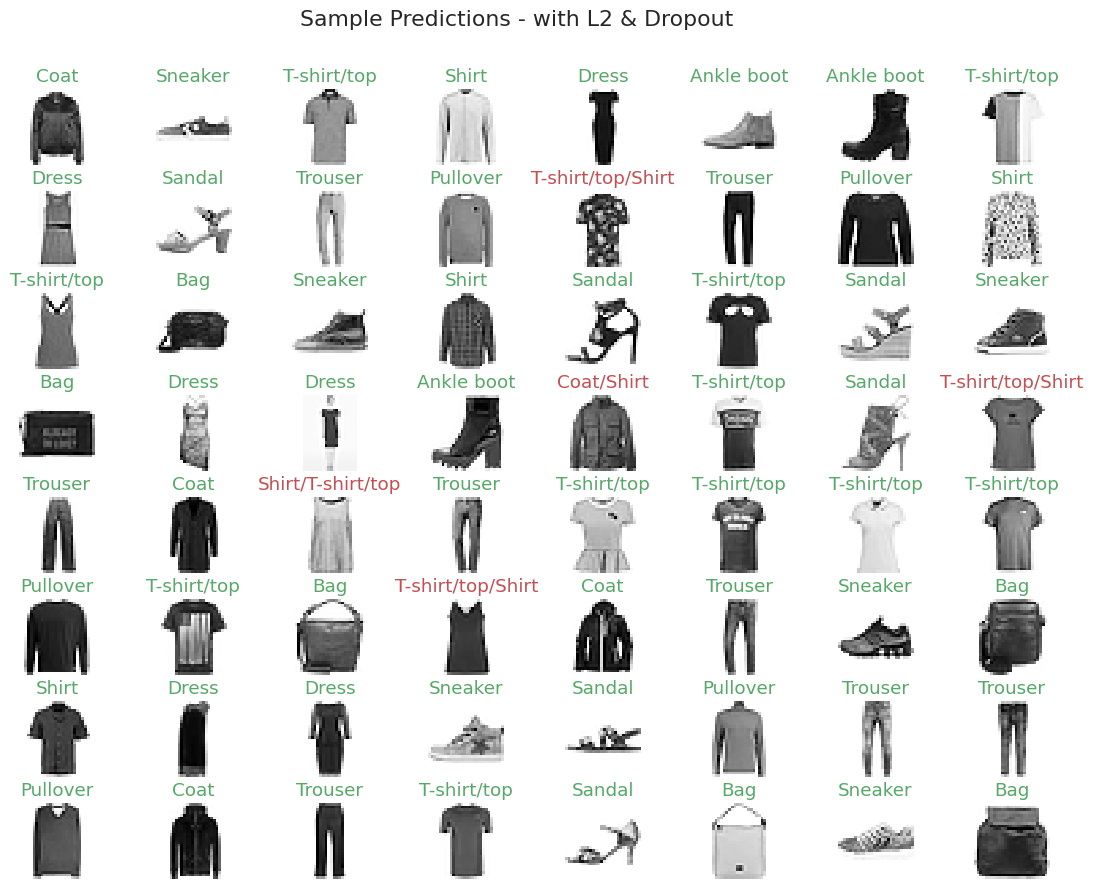

In [86]:
# display sample
print('Displaying sample predictions...')
trainloader = torch.utils.data.DataLoader(
    test_dataset, batch_size = 64, shuffle = True
)
data_iter = iter(trainloader)
images, labels = next(data_iter)  # fetch a batch of 64 random images
preds = trainer.predict(model, images)
preds = np.argmax(preds, axis = 1)
display_sample(
    images, labels.numpy(), sample_predictions = preds,
    grid_shape = (8, 8), plot_title = 'Sample Predictions - with L2 & Dropout'
)

### Conclusion
With the progressive introduction of L2 regularization, dropout regularization and a combination of both, we saw overfitting reducing overall. However, the model's performance on the test dataset did not improve significantly.

We'll need to explore other techniques to further improve performance, such as:
* Training longer (maybe 100 epochs)
* Varying learning rates across epochs - with a learning rate scheduler
* Augmenting training data, using image augmentation techniques
* Using pre-trained models, with fine-tuning.



# <center> -- END -- </center>